### Imports<a id='imports'>
   

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn import metrics
import pmdarima as pm
from pmdarima import auto_arima 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from prophet import Prophet
# Hyperparameter tuning
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
# Process bar
from tqdm import tqdm
# Tracking time
from time import time
import warnings
warnings.filterwarnings('ignore')

### Load Data<a id='load_data'>

In [2]:
#load dataset
df_crimes_summary_gp_apd_code = pd.read_csv('crimes_summary_gp_apd_code.csv', parse_dates=['occurred_date'])

In [3]:
df_crimes_summary_gp_apd_code.head()

,occurred_date,sector,ucr_code,count
0,2003-01-01,ADAM,1000,1
1,2003-01-01,ADAM,1199,1
2,2003-01-01,ADAM,1400,2
3,2003-01-01,ADAM,2100,2
4,2003-01-01,ADAM,2703,2


In [4]:
data2 = df_crimes_summary_gp_apd_code.loc[(df_crimes_summary_gp_apd_code['sector'].isin(['BAKER', 'FRANK', 'IDA', 'DAVID', 'ADAM', 'CHARLIE', 'HENRY',
       'GEORGE', 'EDWARD', 'APT']) ) & (df_crimes_summary_gp_apd_code['ucr_code'].isin([600,601])), ['occurred_date', 'sector', 'ucr_code', 'count']]

In [5]:
data2.shape

(119873, 4)

In [6]:
data2['occurred_date'] = pd.to_datetime(data2['occurred_date'])
data2['year'] = data2['occurred_date'].dt.year

In [7]:
data2.head()

,occurred_date,sector,ucr_code,count,year
12,2003-01-01,ADAM,600,4,2003
13,2003-01-01,ADAM,601,5,2003
31,2003-01-01,BAKER,600,3,2003
32,2003-01-01,BAKER,601,5,2003
52,2003-01-01,CHARLIE,600,4,2003


In [8]:
data2_2022 = data2[data2['year'] >= 2022]

In [9]:
data2_2022.head()

,occurred_date,sector,ucr_code,count,year
916194,2022-01-01,ADAM,600,2,2022
916195,2022-01-01,ADAM,601,1,2022
916207,2022-01-01,BAKER,601,8,2022
916217,2022-01-01,CHARLIE,600,2,2022
916218,2022-01-01,CHARLIE,601,4,2022


In [10]:
data2_2022 = data2_2022.reset_index()

In [11]:
data2_2022.head()

,index,occurred_date,sector,ucr_code,count,year
0,916194,2022-01-01,ADAM,600,2,2022
1,916195,2022-01-01,ADAM,601,1,2022
2,916207,2022-01-01,BAKER,601,8,2022
3,916217,2022-01-01,CHARLIE,600,2,2022
4,916218,2022-01-01,CHARLIE,601,4,2022


In [12]:
data2_2022.drop('index',axis=1,inplace=True)

In [13]:
data2_2022.head()

,occurred_date,sector,ucr_code,count,year
0,2022-01-01,ADAM,600,2,2022
1,2022-01-01,ADAM,601,1,2022
2,2022-01-01,BAKER,601,8,2022
3,2022-01-01,CHARLIE,600,2,2022
4,2022-01-01,CHARLIE,601,4,2022


In [14]:
data2_2022.shape

(6311, 5)

In [15]:
data2_2022.dtypes

occurred_date    datetime64[ns]
sector                   object
ucr_code                  int64
count                     int64
year                      int64
dtype: object

In [16]:
data2_2022['ucr_code'] = data2_2022['ucr_code'].astype(str)

In [17]:
data2_2022.dtypes

occurred_date    datetime64[ns]
sector                   object
ucr_code                 object
count                     int64
year                      int64
dtype: object

### Resampling the data<a id='resampling'>
    
* Upsampling is when the frequency of samples is increased (e.g. days to hours)
* Downsampling is when the frequency of samples is decreased (e.g. days to weeks)
I will do some downsampling with the .resample() function to reduce the noise.

<AxesSubplot:title={'center':'Resampled Weekly'}, xlabel='occurred_date', ylabel='count'>

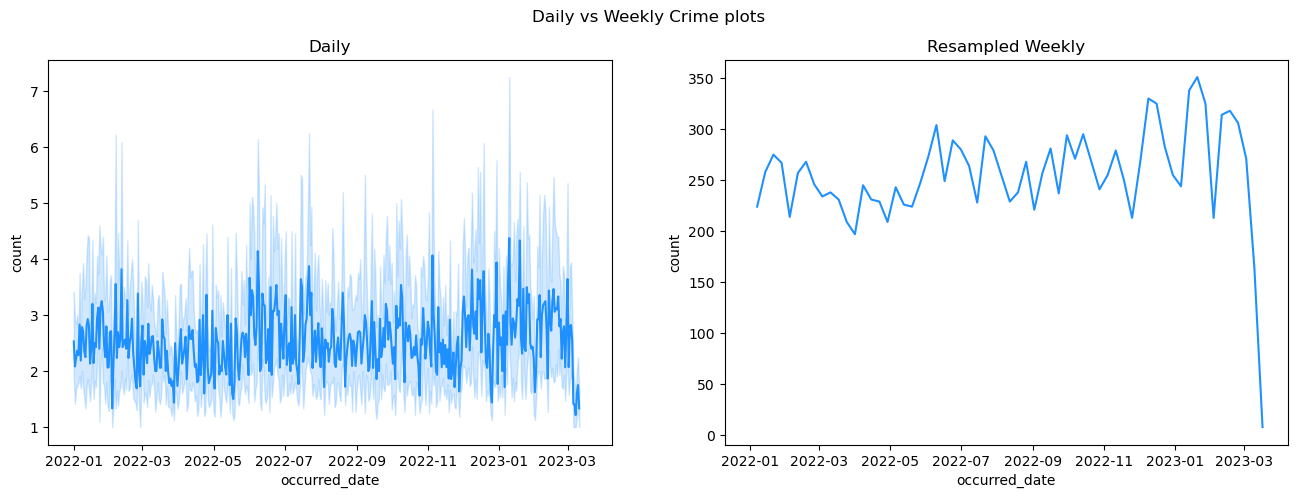

In [18]:
figure, axes = plt.subplots(1, 2, sharex=True,
                            figsize=(16, 5))
figure.suptitle('Daily vs Weekly Crime plots')
axes[0].set_title('Daily')
axes[1].set_title('Resampled Weekly')
sns.lineplot(x='occurred_date', y='count', data = data2_2022, color='dodgerblue', ax=axes[0])
resampled_df = data2_2022[['occurred_date','count']].resample('W-FRI', on='occurred_date').sum().reset_index(drop=False)
sns.lineplot(x='occurred_date', y='count',data=resampled_df, color='dodgerblue', ax=axes[1])


##### Downsampling the data using resample function

I had to use groupby based on categorical variables

In [19]:
weekly_data_adv =  data2_2022.groupby(['ucr_code','sector']).resample('W-FRI', label='right', closed = 'right', on='occurred_date').sum().reset_index().sort_values(by='occurred_date').reset_index()

In [20]:
weekly_data_adv.head()

,index,ucr_code,sector,occurred_date,count,year
0,0,600,ADAM,2022-01-07,13,10110
1,738,601,BAKER,2022-01-07,28,12132
2,1175,601,IDA,2022-01-07,11,8088
3,863,601,DAVID,2022-01-07,17,14154
4,62,600,APT,2022-01-07,1,2022


In [21]:
weekly_data_adv.drop('index',axis=1,inplace=True)

In [22]:
weekly_data_adv.head()

,ucr_code,sector,occurred_date,count,year
0,600,ADAM,2022-01-07,13,10110
1,601,BAKER,2022-01-07,28,12132
2,601,IDA,2022-01-07,11,8088
3,601,DAVID,2022-01-07,17,14154
4,600,APT,2022-01-07,1,2022


In [23]:
weekly_data_adv.year.unique()

array([10110, 12132,  8088, 14154,  2022,  6066,  4044,     0, 10114,
        8091, 14160, 12137,  8092,  2023, 10115, 12138, 14161,  6069,
        4046], dtype=int64)

In [24]:
weekly_data_adv.drop('year',axis=1,inplace=True)

In [25]:
weekly_data_adv.head()

,ucr_code,sector,occurred_date,count
0,600,ADAM,2022-01-07,13
1,601,BAKER,2022-01-07,28
2,601,IDA,2022-01-07,11
3,601,DAVID,2022-01-07,17
4,600,APT,2022-01-07,1


In [26]:
weekly_data_adv[weekly_data_adv['count'] == 0]

,ucr_code,sector,occurred_date,count
139,600,APT,2022-02-25,0
149,601,APT,2022-02-25,0
157,601,APT,2022-03-04,0
191,601,APT,2022-03-11,0
202,601,APT,2022-03-18,0
221,601,APT,2022-03-25,0
257,601,APT,2022-04-08,0
283,600,APT,2022-04-15,0
292,601,APT,2022-04-15,0
340,601,APT,2022-05-06,0


In [27]:
#saving this weekly data  file
csv_name = "wkly_crimes_per_sector_ucr.csv"
weekly_data_adv.to_csv(csv_name, index=False)

In [28]:
weekly_data = pd.read_csv('wkly_crimes_per_sector_ucr.csv', parse_dates=['occurred_date'])

In [29]:
weekly_data.shape

(1237, 4)

In [30]:
# combine sector and ucr_code column as time_series
weekly_data['sector'] = ['sec_' + str(i) for i in weekly_data['sector']]
weekly_data['ucr_code'] = ['code_' + str(i) for i in weekly_data['ucr_code']]
weekly_data['time_series'] = weekly_data[['sector', 'ucr_code']].apply(lambda x: '_'.join(x), axis=1)

In [31]:
weekly_data = weekly_data.rename(columns={'occurred_date': 'ds', 'count': 'y'})

In [32]:
weekly_data.head()

,ucr_code,sector,ds,y,time_series
0,code_600,sec_ADAM,2022-01-07,13,sec_ADAM_code_600
1,code_601,sec_BAKER,2022-01-07,28,sec_BAKER_code_601
2,code_601,sec_IDA,2022-01-07,11,sec_IDA_code_601
3,code_601,sec_DAVID,2022-01-07,17,sec_DAVID_code_601
4,code_600,sec_APT,2022-01-07,1,sec_APT_code_600


In [33]:
weekly_data.columns

Index(['ucr_code', 'sector', 'ds', 'y', 'time_series'], dtype='object')

## Split Data<a id='split_data'>

In [34]:
train_w = weekly_data[weekly_data['ds'] <= '2022-12-30'].copy()
test_w = weekly_data[weekly_data['ds'] > '2022-12-30'].copy()

In [35]:
train_w.shape, test_w.shape

((1034, 5), (203, 5))

In [36]:
#train_size = int(0.82 * len(weekly_data))
#test_size = len(weekly_data) - train_size

In [37]:
prophet_df = weekly_data

In [38]:
#train = prophet_df.iloc[:train_size, :]

In [39]:
#train.shape

In [40]:
#test = prophet_df.iloc[train_size:, :]

In [41]:
#test.shape

In [42]:
train_w.head()

,ucr_code,sector,ds,y,time_series
0,code_600,sec_ADAM,2022-01-07,13,sec_ADAM_code_600
1,code_601,sec_BAKER,2022-01-07,28,sec_BAKER_code_601
2,code_601,sec_IDA,2022-01-07,11,sec_IDA_code_601
3,code_601,sec_DAVID,2022-01-07,17,sec_DAVID_code_601
4,code_600,sec_APT,2022-01-07,1,sec_APT_code_600


In [43]:
train_w.iloc[:,3]

0       13
1       28
2       11
3       17
4        1
        ..
1029    40
1030    10
1031    10
1032     3
1033    10
Name: y, Length: 1034, dtype: int64

In [44]:
#x_train, y_train = pd.DataFrame(prophet_df.iloc[:train_size, 2]), pd.DataFrame(prophet_df.iloc[:train_size, 3])

In [45]:
x_train, y_train = pd.DataFrame(train_w.iloc[:,2]), pd.DataFrame(train_w.iloc[:,3])

In [46]:
x_train.shape, y_train.shape #x_train = ds columns and y_train will have y columns

((1034, 1), (1034, 1))

In [47]:
x_test, y_test = pd.DataFrame(test_w.iloc[:,2]), pd.DataFrame(test_w.iloc[:,3])

In [48]:
x_test.shape, y_test.shape #x_test = ds columns and y_test will have y columns

((203, 1), (203, 1))

In [49]:
print(len(train_w), len(test_w))

1034 203


In [50]:
# Group the data by sectors(sector)
groups_by_sector = weekly_data.groupby('sector')

In [51]:
len(groups_by_sector)

10

In [52]:
type(groups_by_sector)

pandas.core.groupby.generic.DataFrameGroupBy

In [53]:
# Check the groups in the dataframe
groups_by_sector.groups.keys()

dict_keys(['sec_ADAM', 'sec_APT', 'sec_BAKER', 'sec_CHARLIE', 'sec_DAVID', 'sec_EDWARD', 'sec_FRANK', 'sec_GEORGE', 'sec_HENRY', 'sec_IDA'])

In [54]:
sector_list = ['sec_ADAM', 'sec_APT', 'sec_BAKER', 'sec_CHARLIE', 'sec_DAVID', 'sec_EDWARD', 'sec_FRANK', 'sec_GEORGE', 'sec_HENRY', 'sec_IDA']

In [55]:
# Group the data by ucr_code
groups_by_ucr_code = weekly_data.groupby('ucr_code')

In [56]:
len(groups_by_ucr_code)

2

In [57]:
# Check the groups in the dataframe
groups_by_ucr_code.groups.keys()

dict_keys(['code_600', 'code_601'])

In [58]:
ucr_code_list = ['code_600', 'code_601']

In [59]:
# Group the data by ucr_code
groups_by_time_series = weekly_data.groupby(['time_series'])

In [60]:
len(groups_by_time_series)

20

In [61]:
# Check the groups in the dataframe
groups_by_time_series.groups.keys()

dict_keys(['sec_ADAM_code_600', 'sec_ADAM_code_601', 'sec_APT_code_600', 'sec_APT_code_601', 'sec_BAKER_code_600', 'sec_BAKER_code_601', 'sec_CHARLIE_code_600', 'sec_CHARLIE_code_601', 'sec_DAVID_code_600', 'sec_DAVID_code_601', 'sec_EDWARD_code_600', 'sec_EDWARD_code_601', 'sec_FRANK_code_600', 'sec_FRANK_code_601', 'sec_GEORGE_code_600', 'sec_GEORGE_code_601', 'sec_HENRY_code_600', 'sec_HENRY_code_601', 'sec_IDA_code_600', 'sec_IDA_code_601'])

In [62]:
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    ##r2_square = metrics.r2_score(true, predicted)
   # ybar = np.sum(true) / len(true) #yes, we could use np.mean(y)
    #sum_sq_tot = np.sum((true - ybar)**2) #total sum of squares error
    #sum_sq_res = np.sum((true - predicted)**2) #residual sum of squares error
   # r2_square = 1.0 - sum_sq_res / sum_sq_tot
    ###
    ape = np.abs((true - predicted)/true)
    ape[~np.isfinite(ape)] = 1
    mape=round((np.mean(ape) *100),2)
    ### to calculate WMAPE, weighted MAPE, we need to first calculate weighter error. sum(weighter error) /sum(actual)
    #weighted error is calculated as: |actual-forecast| / |actual| * 100 * actual
    wmape=round((np.sum(abs(true-predicted))/np.sum(true)) * 100,2)
    return mae, mse, rmse, mape, wmape

In [63]:
def train_and_forecast(data_ts):
    # Initiate the model
      m = Prophet()
  
      # Fit the model
      m.fit(data_ts)
      # Make predictions
      future = m.make_future_dataframe(periods=14)
      forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
      #forecast['sector'] = data_ts['time_series'].iloc[0]
      forecast['y'] = data_ts['y'].iloc[0]
      # Return the forecasted results
      return forecast[['ds','y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [64]:
%%time
# Start time
start_time = time()
# Create an empty dataframe
for_loop_forecast = pd.DataFrame()
# Loop through each sector
eval_results_df = pd.DataFrame()
for sector in sector_list:
    for code in ucr_code_list:
        ts_code = '_'.join([sector, code])
        #store_sec = sector
        #print("BEFORE store sec: ",store_sec)
        #eval_results.append(store_sec)
        #print("BEFORE: ",eval_results)
        # Get the data for the time_series code
        group = groups_by_time_series.get_group(ts_code)  
        #print("group: ",group)
        # Make forecast
        forecast = train_and_forecast(group)
        # use the model to make a forecast

        # calculate MAE between expected and predicted values
        y_true = forecast['y'].values
        y_pred = forecast['yhat'].values
        #mae = mean_absolute_error(y_true, y_pred)
        #print('MAE: %.3f' % mae)
        #predictions = forecast.iloc[-110:]['yhat']
        #print("predictions: ",predictions)
        #print("Root Mean Square: ",rmse(test_w['y'],predictions))
        # Add the forecast results to the dataframe
        for_loop_forecast = pd.concat((for_loop_forecast, forecast))
        #print("after: ",eval_results)
        results_df_2 = pd.DataFrame(data=[[ts_code, *evaluate(y_true,y_pred)]], 
                              columns=['Time Series', 'MAE', 'MSE', 'RMSE', 'MAPE', 'WMAPE'])
        eval_results_df = eval_results_df.append(results_df_2, ignore_index=True)
        print('The time used for the for-loop forecast is ', time()-start_time)
        #plot(forecast)
# Take a look at the data
#for_loop_forecast.head()
#for_loop_forecast.tail()
#eval_results_df


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  5.581634521484375


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  8.297053575515747


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  11.236279249191284


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  13.429924488067627


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  15.703993320465088


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  20.10356092453003


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  24.38818335533142


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  28.842283725738525


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  31.619232177734375


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  34.811140060424805


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  37.54345417022705


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  40.09690546989441


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  43.6640043258667


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  45.72512078285217


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  48.11763119697571


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  50.51707863807678


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  52.75557017326355


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  55.054041147232056


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The time used for the for-loop forecast is  57.78827905654907
The time used for the for-loop forecast is  60.398311138153076
Wall time: 1min


In [65]:
eval_results_df

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_600,1.334096,2.538975,1.593416,10.26,10.26
1,sec_ADAM_code_601,9.423199,106.754033,10.332184,52.35,52.35
2,sec_APT_code_600,1.618419,2.786569,1.669302,161.84,161.84
3,sec_APT_code_601,0.441507,0.269545,0.519177,44.15,44.15
4,sec_BAKER_code_600,1.884772,3.749407,1.936338,23.56,23.56
5,sec_BAKER_code_601,5.838103,34.176730,5.846087,20.85,20.85
6,sec_CHARLIE_code_600,1.875406,3.531628,1.879263,26.79,26.79
7,sec_CHARLIE_code_601,6.741954,45.468669,6.743046,39.66,39.66
8,sec_DAVID_code_600,1.442526,2.740163,1.655344,11.10,11.10
9,sec_DAVID_code_601,17.473197,329.100484,18.141127,102.78,102.78


In [66]:
eval_results_df.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,3.976424,34.833690,4.143110,41.647500,41.647500
std,4.175353,75.284036,4.312568,37.160876,37.160876
min,0.441507,0.269545,0.519177,5.780000,5.780000
25%,1.415418,2.689866,1.639862,16.432500,16.432500
50%,2.265601,5.410568,2.301527,35.665000,35.665000
75%,5.703527,33.363172,5.775944,49.372500,49.372500
max,17.473197,329.100484,18.141127,161.840000,161.840000


In [67]:
eval_results_df.set_index('Time Series',inplace=True)

Text(0.6, 0.5, 'ucr_code:\n600-THEFTS\n601-BURGLARY')

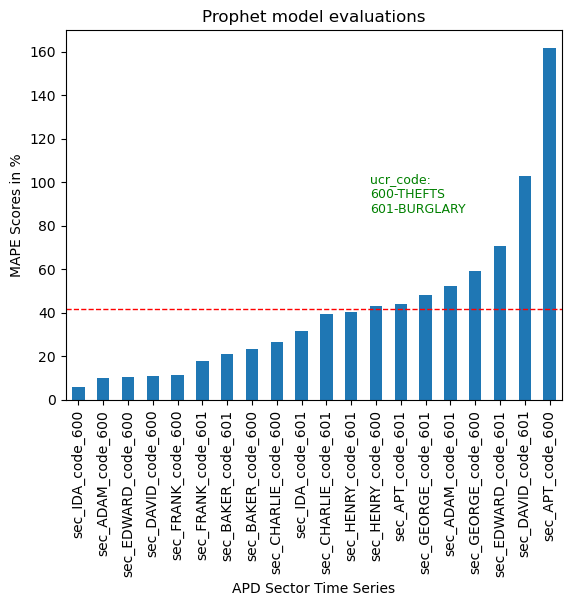

In [68]:
df_sorted = eval_results_df.sort_values('MAPE')

df_sorted['MAPE'].plot(kind="bar")
plt.title("Prophet model evaluations")
xlocs, xlabs = plt.xticks()
plt.xlabel("APD Sector Time Series")
plt.ylabel("MAPE Scores in %")
mape_mean = round(np.mean(eval_results_df['MAPE']),2)
plt.axhline(mape_mean,linewidth=1,color='r',linestyle='--')
text_pos_x = 0.60
text_pos_y = 0.50
plt.text(text_pos_x, text_pos_y, "ucr_code:\n600-THEFTS\n601-BURGLARY", fontsize=9,
transform=plt.gcf().transFigure, color='green')

APT sector shows high MAPE scores probably due to lack of data in that sector. Refer Cell# 26 There are no crimes recorded for APT sector. 

Prophet model predicted some good results for some sectors like IDA, ADAM, EDWARD, DAVID, FRANK for Theft crime as they are below 20% 

In [69]:
import math
model = Prophet()
model.fit(train_w)
# Predict on valid set
y_pred = model.predict(x_test)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


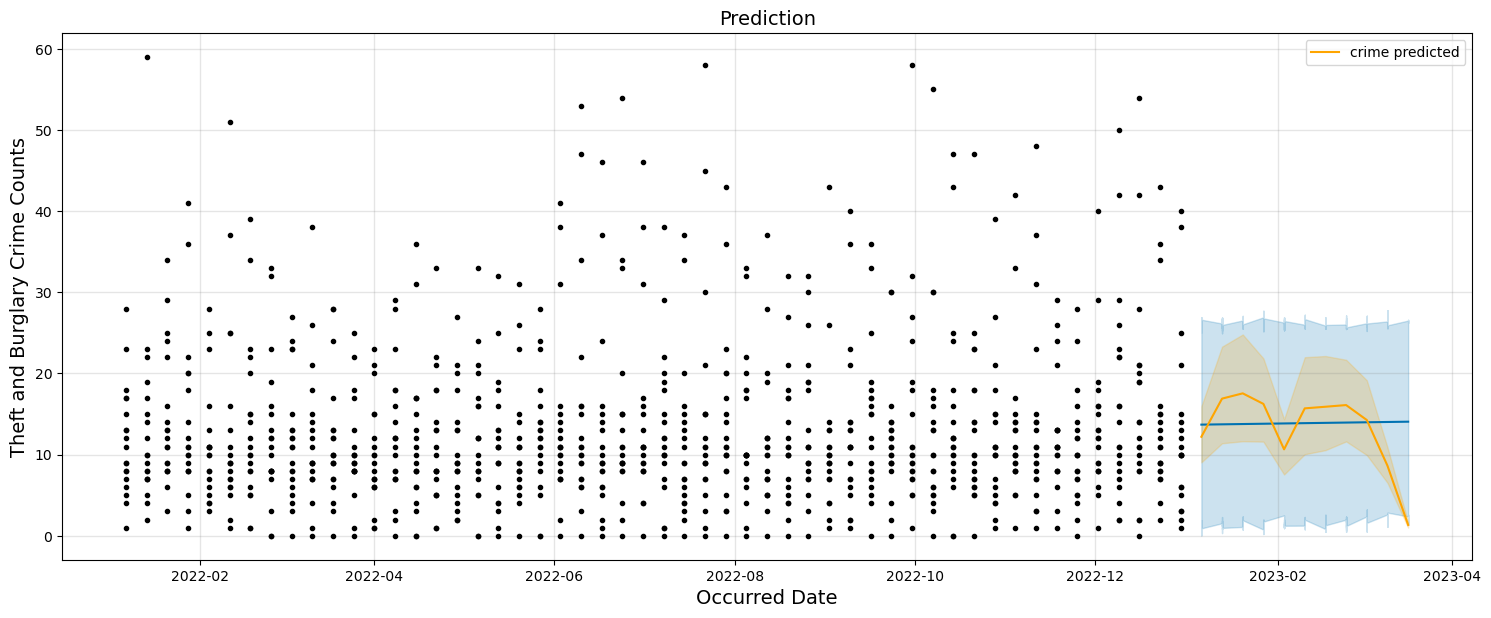

In [70]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_test['ds'], y=y_test['y'], ax=ax, color='orange', label='crime predicted') #navajowhite

ax.set_title(f'Prediction', fontsize=14)
ax.set_xlabel(xlabel='Occurred Date', fontsize=14)
ax.set_ylabel(ylabel='Theft and Burglary Crime Counts', fontsize=14)

plt.show()

## PMDARIMA<a id='pmdarima'>

we can use pmdarima’s ADFTest() function to conduct a Dickey-Fuller test

In [88]:
# Group the data by ucr_code
groups_by_time_series_arima = train_w.groupby(['time_series'])

In [71]:
import pmdarima as pmd

In [72]:
train_w.set_index('ds',inplace=True)

In [73]:
train_w.head()

,ucr_code,sector,y,time_series
ds,,,,
2022-01-07,code_600,sec_ADAM,13,sec_ADAM_code_600
2022-01-07,code_601,sec_BAKER,28,sec_BAKER_code_601
2022-01-07,code_601,sec_IDA,11,sec_IDA_code_601
2022-01-07,code_601,sec_DAVID,17,sec_DAVID_code_601
2022-01-07,code_600,sec_APT,1,sec_APT_code_600


In [74]:
train_w['y'].shape

(1034,)

In [75]:
test_w.set_index('ds',inplace=True)

In [76]:
test_w.head()

,ucr_code,sector,y,time_series
ds,,,,
2023-01-06,code_600,sec_IDA,10,sec_IDA_code_600
2023-01-06,code_600,sec_BAKER,6,sec_BAKER_code_600
2023-01-06,code_600,sec_EDWARD,16,sec_EDWARD_code_600
2023-01-06,code_601,sec_ADAM,22,sec_ADAM_code_601
2023-01-06,code_600,sec_ADAM,8,sec_ADAM_code_600


In [77]:
def arima_forecast_to_df(model, steps=12):
    #print("steps: ",steps)
    forecast = model.predict(n_periods=steps)
    #print("FORECAST: ",forecast)
    return forecast

In [78]:
def arimamodel(timeseriesarray):
    future_forecast = pd.DataFrame()
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                                     d=1,
                              test="kpss",
                              trace=True)
    return autoarima_model

In [79]:
weekly_data.set_index('ds',inplace=True)

In [91]:
%%time
# Start time
start_time = time()
# Create an empty dataframe
for_loop_forecast = pd.DataFrame()
# Loop through each sector
eval_results_df = pd.DataFrame()
for sector in sector_list:
    for code in ucr_code_list:
        ts_code = '_'.join([sector, code])
        group = groups_by_time_series_arima.get_group(ts_code)
        #print("GROUP: ",group)
        # Make forecast
        arima_model = arimamodel(group["y"])
        arima_model.summary()
        arima_model.fit(train_w["y"])
        future_forecast = arima_model.predict(n_periods=test_w.shape[0])
        # Returns a dataframe
        #forecast = arima_forecast_to_df(arima_model, steps = test_w.shape[0])
        print("PRED: ",future_forecast)
        future_forecast = pd.DataFrame(future_forecast,columns=['Prediction'])
        print("future_forecast",future_forecast.head())
        #test_w.head()
        #test_w['predicted_counts'] = forecast
        #test_w[["y", "predicted_counts"]].plot(figsize=(14, 7))
        y_pred = future_forecast['Prediction'].values
        y_true = test_w['y'].values
        # Model Evaluation
        results_df_2 = pd.DataFrame(data=[[ts_code,  *evaluate(y_true, y_pred)]], 
                              columns=['Time Series', 'MAE', 'MSE', 'RMSE', 'MAPE', 'WMAPE'])
        eval_results_df = eval_results_df.append(results_df_2, ignore_index=True)
        
        print('The time used for the for-loop forecast is ', time()-start_time)
        print("eval results: ",eval_results_df) 


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=334.011, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=319.915, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=332.011, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=314.002, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=313.818, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=314.633, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=311.902, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=312.021, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=312.811, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=248.209, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=211.296, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=210.594, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=212.186, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=208.599, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=228.956, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=210.195, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=209.304, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=210.403, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=209.027, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.917 seconds
PRED:  [7.37369927 7.02286803 8.06402026 7.46249898 7.55387228 7.67544249
 7.56477601 7.60296537 7.6107793  7.59379344 7.60296836 7.60191233
 7.5998281

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.906 seconds
PRED:  [6.34889001 8.25326203 7.25996607 7.77805647 7.50782718 7.6487753
 7.57525858 7.61360396 7.5936035  7.60403548 7.59859429 7.60143235
 7.59995205 7.60072416 7.60032144 7.60053149 7.60042193 7.60047907
 7.60044927 7.60046482 7.60045671 7.60046094 7.60045873 7.60045988
 7.60045928 7.60045959 7.60045943 7.60045952 7.60045947 7.60045949
 7.60045948 7.60045949 7.60045948 7.60045949 7.60045949 7.60045949
 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949
 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949
 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949
 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949
 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949
 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949 7.60045949
 7.60045949 7.60045949 7.60045949 7.60045949 7.60045

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=256.609, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=266.078, Time=0.02 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 2.964 seconds
PRED:  [13.09816051 13.18448217 13.24934608 13.24985747 13.25124237 13.25122464
 13.2512548  13.25125379 13.25125446 13.25125443 13.25125444 13.25125444
 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444
 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444
 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444
 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444
 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444
 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444
 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444 13.25125444
 13.251

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=296.583, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=301.168, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=298.557, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=298.347, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=290.779, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=289.765, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=290.806, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=292.042, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.933 seconds
PRED:  [13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.254

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=311.982, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=313.559, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=313.527, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=325.044, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=315.517, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.775 seconds
PRED:  [13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.254

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=322.974, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=321.066, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=323.441, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=318.992, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=319.192, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=326.711, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=320.968, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=320.976, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=319.067, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=321.471, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 0.888 seconds
PRED:  [13.34902723 13.27742283 13.27895378 13.27892105 13.27892175 13.27892173
 13.27892173 13.27892173 13.27892173 13.27892173 13.27892173 13.2789217

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=288.445, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=279.658, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=280.061, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=277.685, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=280.540, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=278.123, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.280 seconds
PRED:  [7.37369927 7.02286803 8.06402026 7.46249898 7.55387228 7.67544249
 7.56477601 7.60296537 7.6107793  7.59379344 7.60296836 7.60191233
 7.59982819 7.60156946 7.6

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=339.100, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=332.501, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=322.579, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=337.138, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=324.586, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=320.769, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=330.579, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.006 seconds
PRED:  [13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098 13.25470098
 13.254700

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=350.077, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=327.421, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=323.649, Time=0.08 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=322.135, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=324.091, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=320.155, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=321.657, Time=0.02 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=322.112, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total 

In [92]:
eval_results_df

,Time Series,MAE,MSE,RMSE,MAPE,WMAPE
0,sec_ADAM_code_600,8.426562,175.712877,13.255673,91.69,59.98
1,sec_ADAM_code_601,8.120871,138.441707,11.766125,142.17,57.80
2,sec_APT_code_600,8.557915,179.372012,13.392984,90.15,60.91
3,sec_APT_code_601,8.128522,138.406049,11.764610,142.48,57.86
4,sec_BAKER_code_600,8.571889,179.450740,13.395923,90.32,61.01
5,sec_BAKER_code_601,8.120871,138.441707,11.766125,142.17,57.80
6,sec_CHARLIE_code_600,8.118768,138.437830,11.765961,142.11,57.79
7,sec_CHARLIE_code_601,8.120871,138.441707,11.766125,142.17,57.80
8,sec_DAVID_code_600,8.120871,138.441707,11.766125,142.17,57.80
9,sec_DAVID_code_601,7.773399,154.206897,12.418007,106.31,55.33


In [93]:
eval_results_df.describe()

,MAE,MSE,RMSE,MAPE,WMAPE
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,8.193773,150.129863,12.233624,125.681500,58.320500
std,0.225837,17.629582,0.702112,23.568232,1.606868
min,7.773399,138.393621,11.764082,90.150000,55.330000
25%,8.120871,138.437830,11.765961,101.995000,57.800000
50%,8.120871,138.441707,11.766125,142.170000,57.800000
75%,8.207122,160.579947,12.667463,142.170000,58.420000
max,8.571889,179.450740,13.395923,142.710000,61.010000


In [94]:
eval_results_df.set_index('Time Series',inplace=True)

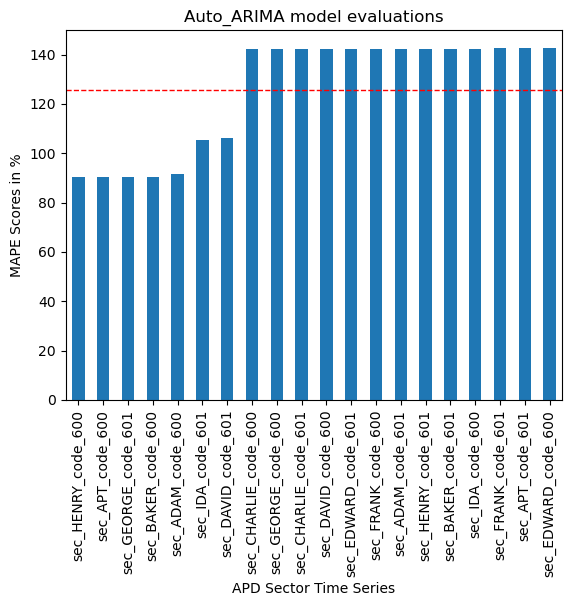

In [97]:
df_sorted = eval_results_df.sort_values('MAPE')

df_sorted['MAPE'].plot(kind="bar")
plt.title("Auto_ARIMA model evaluations")
xlocs, xlabs = plt.xticks()
plt.xlabel("APD Sector Time Series")
plt.ylabel("MAPE Scores in %")
mape_mean = round(np.mean(eval_results_df['MAPE']),2)
plt.axhline(mape_mean,linewidth=1,color='r',linestyle='--')


Auto_arima is not predicting correctly. Does it require differencing?